In [1]:
!git clone https://github.com/Copeliaminutti/Proyecto-MLOps.git
%cd Proyecto-MLOps

Cloning into 'Proyecto-MLOps'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 572 (delta 75), reused 158 (delta 55), pack-reused 381 (from 1)
Receiving objects: 100% (572/572), 11.51 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (200/200), done.
/content/Proyecto-MLOps


In [3]:
!ls

app.py	   docs		    LICENSE    QUICKSTART.md	 src
artifacts  dvc.lock	    Makefile   README.md	 tests
configs    dvc.yaml	    models     reports		 test_s3.txt.dvc
data	   environment.yml  notebooks  requirements.txt


In [4]:
!ls data

interim  processed  raw


In [6]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

plt.rcParams["figure.figsize"] = (6,4)

# 1) Cargar artefactos del modelo (best_model.pkl)
artifacts = joblib.load("models/best_model.pkl")
best_model_name = artifacts["best_model"]
model = artifacts["models"][best_model_name]

print("Mejor modelo:", best_model_name)
print("Tipo de modelo:", type(model))

df = pd.read_csv("data/raw/steel_energy_clean_fullgrid.csv")
print("Shape dataset:", df.shape)
df.head()


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid resul

Mejor modelo: RandomForestRegressor
Tipo de modelo: <class 'sklearn.pipeline.Pipeline'>
Shape dataset: (35740, 12)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.0,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.5,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


In [12]:
# 3) Separar features (X) y target (y)
target_col = "Usage_kWh"
y = df[target_col]
X = df.drop(columns=[target_col])

# Usamos el 20% final como "validación" (simulación de último período)
val_frac = 0.2
n_val = int(len(df) * val_frac)

X_val = X.iloc[-n_val:].copy()
y_val = y.iloc[-n_val:].copy()

print("Validación X:", X_val.shape)
print("Validación y:", y_val.shape)
X_val.head()


Validación X: (7148, 11)
Validación y: (7148,)


,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
28592,25/10/2018 20:15,26.17,0.0,0.02,89.83,100.0,72900.0,Weekday,Thursday,Medium_Load,801
28593,25/10/2018 20:30,29.05,0.0,0.03,88.99,100.0,73800.0,Weekday,Thursday,Medium_Load,634
28594,25/10/2018 20:45,34.34,0.0,0.04,92.07,100.0,74700.0,Weekday,Thursday,Medium_Load,NaN
28595,25/10/2018 21:00,30.35,0.0,0.03,92.7,100.0,75600.0,Weekday,Thursday,Medium_Load,988
28596,25/10/2018 21:15,0.25,15.73,0.0,99.96,49.2,76500.0,Weekday,Thursday,Medium_Load,434


In [15]:
target_col = "usage_kwh"

y = features_df[target_col]
X = features_df.drop(columns=[target_col])

# Usamos el 20% final como validación
val_frac = 0.2
n_val = int(len(features_df) * val_frac)

X_val = X.iloc[-n_val:].copy()
y_val = y.iloc[-n_val:].copy()

print("Validación X:", X_val.shape)
print("Validación y:", y_val.shape)
X_val.head()


Validación X: (6598, 48)
Validación y: (6598,)


,day_status_num,lagging_current_reactive_power_kvarh,leading_current_reactive_power_kvarh,co2_tco2,lagging_current_power_factor,leading_current_power_factor,nsm,mixed_type_col,mixed_type_col_num,week_status_Weekday,...,week_status_raw_ wEEKEND,week_status_raw_Weekday,week_status_raw_Weekend,load_type_raw_ NAN,load_type_raw_ lIGHT_lOAD,load_type_raw_ mAXIMUM_lOAD,load_type_raw_ mEDIUM_lOAD,load_type_raw_Light_Load,load_type_raw_Maximum_Load,load_type_raw_Medium_Load
26396,1.0,5.94,0.0,0.000000,47.08,100.0,22500.0,498.800035,498.800035,False,...,False,False,True,False,True,False,False,False,False,False
26397,1.0,4.93,0.0,0.000000,49.52,100.0,23400.0,969.000000,969.000000,False,...,False,False,True,False,False,False,False,True,False,False
26398,1.0,5.04,0.0,0.000000,49.09,100.0,24300.0,76.000000,76.000000,False,...,False,False,True,False,False,False,False,True,False,False
26399,1.0,4.90,0.0,0.000000,50.15,100.0,25200.0,875.000000,875.000000,False,...,False,False,True,False,False,False,False,True,False,False
26400,1.0,4.79,0.0,0.001329,51.53,100.0,26100.0,131.000000,131.000000,False,...,False,False,True,False,False,False,False,True,False,False


In [16]:
# 6) Calcular métricas base (sin drift)
y_pred = model.predict(X_val)

baseline_r2 = r2_score(y_val, y_pred)
baseline_mae = mean_absolute_error(y_val, y_pred)

print(f"Baseline R²: {baseline_r2:.3f}")
print(f"Baseline MAE: {baseline_mae:.3f}")


Baseline R²: 0.879
Baseline MAE: 3.775


In [33]:
# 7) Simular Data Drift
X_drift = X_val.copy()

# Cambios numéricos
if "co2_tco2" in X_drift.columns:
    X_drift["co2_tco2"] = X_drift["co2_tco2"] + np.random.normal(10, 3, len(X_drift))

for col in ["lagging_current_power_factor", "leading_current_power_factor"]:
    if col in X_drift.columns:
        X_drift[col] = X_drift[col] * np.random.uniform(0.8, 0.9, len(X_drift))

if "nsm" in X_drift.columns:
    X_drift["nsm"] = X_drift["nsm"] + np.random.normal(500, 100, len(X_drift))

# Cambios categóricos (ya codificados como dummies)
# simular más fines de semana
for col in X_drift.columns:
    if "week_status_Weekend" in col:
        X_drift[col] = np.where(np.random.rand(len(X_drift)) > 0.7, 1, 0)

print("Muestra de datos con drift:")
X_drift.head()


Muestra de datos con drift:


,day_status_num,lagging_current_reactive_power_kvarh,leading_current_reactive_power_kvarh,co2_tco2,lagging_current_power_factor,leading_current_power_factor,nsm,mixed_type_col,mixed_type_col_num,week_status_Weekday,...,week_status_raw_ wEEKEND,week_status_raw_Weekday,week_status_raw_Weekend,load_type_raw_ NAN,load_type_raw_ lIGHT_lOAD,load_type_raw_ mAXIMUM_lOAD,load_type_raw_ mEDIUM_lOAD,load_type_raw_Light_Load,load_type_raw_Maximum_Load,load_type_raw_Medium_Load
26396,1.0,5.94,0.0,10.896357,42.020156,88.616437,23015.817168,498.800035,498.800035,False,...,False,False,True,False,True,False,False,False,False,False
26397,1.0,4.93,0.0,9.109595,42.608226,87.814045,23734.310116,969.000000,969.000000,False,...,False,False,True,False,False,False,False,True,False,False
26398,1.0,5.04,0.0,11.419519,39.659550,83.938809,24820.930742,76.000000,76.000000,False,...,False,False,True,False,False,False,False,True,False,False
26399,1.0,4.90,0.0,6.756632,42.452463,83.272591,25632.376246,875.000000,875.000000,False,...,False,False,True,False,False,False,False,True,False,False
26400,1.0,4.79,0.0,10.150442,44.156798,84.326147,26703.587054,131.000000,131.000000,False,...,False,False,True,False,False,False,False,True,False,False


In [18]:
# 8) Evaluar el modelo sobre los datos con drift
y_pred_drift = model.predict(X_drift)

drift_r2 = r2_score(y_val, y_pred_drift)
drift_mae = mean_absolute_error(y_val, y_pred_drift)

print(f"Post-Drift R²: {drift_r2:.3f}")
print(f"Post-Drift MAE: {drift_mae:.3f}")


Post-Drift R²: -0.164
Post-Drift MAE: 24.595


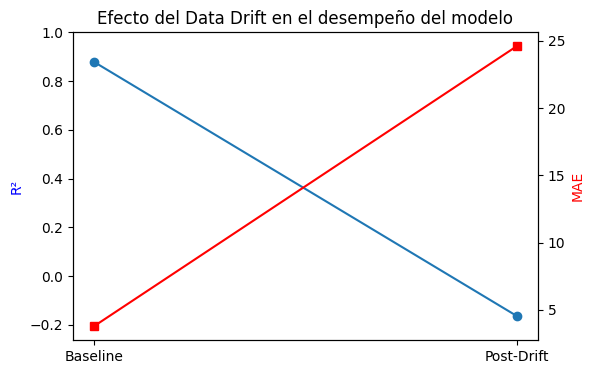

In [19]:
# 9) Visualizar el impacto del drift en R² y MAE
stages = ["Baseline", "Post-Drift"]

r2_values = [baseline_r2, drift_r2]
mae_values = [baseline_mae, drift_mae]

fig, ax1 = plt.subplots()

ax1.plot(stages, r2_values, marker="o", label="R²")
ax1.set_ylabel("R²", color="blue")
ax1.set_ylim(min(0, drift_r2 - 0.1), 1)
ax1.set_title("Efecto del Data Drift en el desempeño del modelo")

ax2 = ax1.twinx()
ax2.plot(stages, mae_values, marker="s", color="red", label="MAE")
ax2.set_ylabel("MAE", color="red")

plt.show()


In [20]:
# 10) Detección automática de Data Drift
r2_drop = baseline_r2 - drift_r2
mae_increase = drift_mae - baseline_mae

# Definimos umbrales de alerta
if r2_drop > 0.2 or mae_increase > 5:
    alerta = "Posible Data Drift detectado: revisar el pipeline o reentrenar el modelo."
else:
    alerta = "Modelo estable, sin evidencia significativa de drift."

print(alerta)
print(f"Diferencia R²: {r2_drop:.3f} | Diferencia MAE: {mae_increase:.3f}")


Posible Data Drift detectado: revisar el pipeline o reentrenar el modelo.
Diferencia R²: 1.042 | Diferencia MAE: 20.820


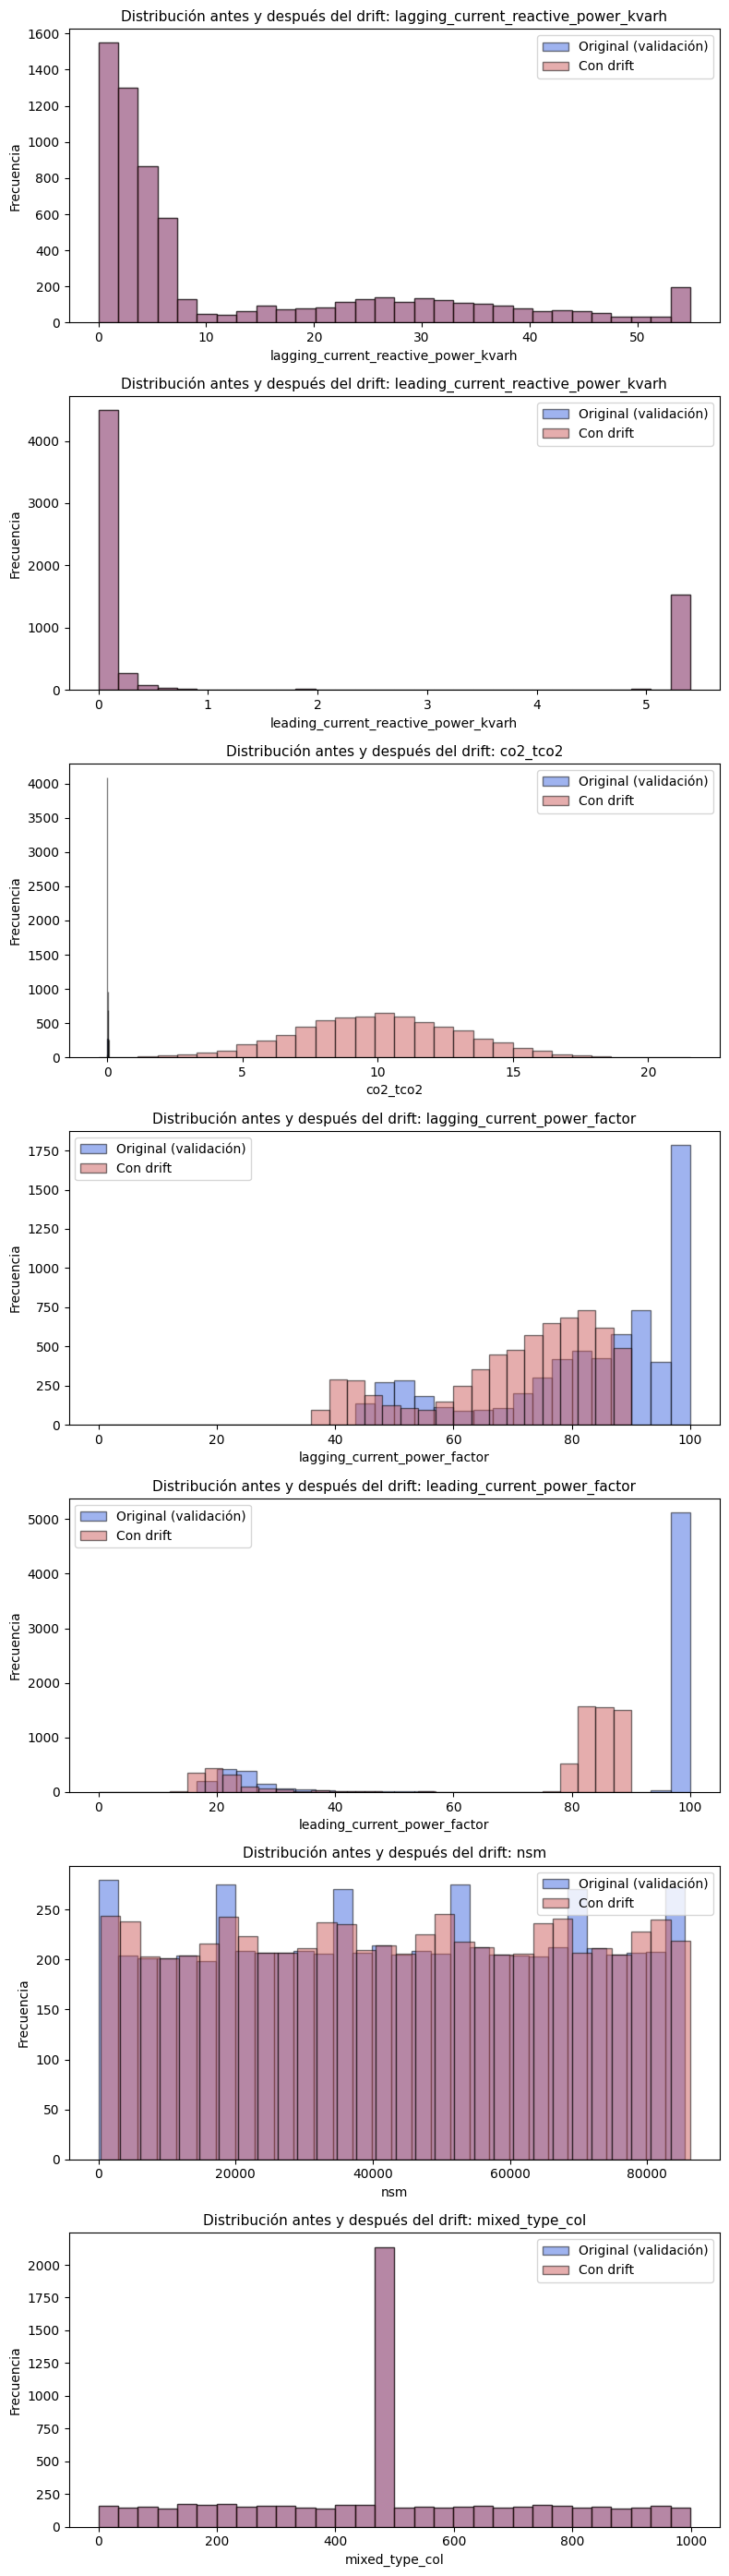

In [24]:
import matplotlib.pyplot as plt

# Lista de variables numéricas en el dataset
numeric_cols = [
    'lagging_current_reactive_power_kvarh',
    'leading_current_reactive_power_kvarh',
    'co2_tco2',
    'lagging_current_power_factor',
    'leading_current_power_factor',
    'nsm',
    'mixed_type_col'
]

fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(8, 4*len(numeric_cols)))

for i, feature in enumerate(numeric_cols):
    ax = axes[i] if len(numeric_cols) > 1 else axes

    ax.hist(X_val[feature], bins=30, alpha=0.5, color='royalblue', label='Original (validación)', edgecolor='black')
    ax.hist(X_drift[feature], bins=30, alpha=0.5, color='indianred', label='Con drift', edgecolor='black')

    ax.set_title(f'Distribución antes y después del drift: {feature}', fontsize=11)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frecuencia')
    ax.legend()

plt.tight_layout()
plt.show()


In [25]:
!pip install reportlab matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.8 MB/s eta 0:00:00


In [32]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

try:
    X_drift_df = X_val_drift
except NameError:
    X_drift_df = X_drift

# Lista de variables numéricas relevantes
numeric_cols = [
    "lagging_current_reactive_power_kvarh",
    "leading_current_reactive_power_kvarh",
    "co2_tco2",
    "lagging_current_power_factor",
    "leading_current_power_factor",
    "nsm",
    "mixed_type_col",
]

# Crear el PDF
pdf_path = "data_drift_histograms_all_vars.pdf"

with PdfPages(pdf_path) as pdf:
    for col in numeric_cols:
        plt.figure(figsize=(8, 5))
        plt.hist(X_val[col], bins=30, alpha=0.6, density=True, label="Validación original")
        plt.hist(X_drift_df[col], bins=30, alpha=0.6, density=True, label="Con drift (simulado)")
        plt.title(f"Comparación de distribuciones antes y después del drift\nVariable: {col}")
        plt.xlabel(col)
        plt.ylabel("Densidad")
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f"PDF generado exitosamente: {pdf_path}")


PDF generado exitosamente: data_drift_histograms_all_vars.pdf


*Implementa umbrales y criterios de alerta y una acción propuestaI

In [31]:
import os
from datetime import datetime, timezone
import pandas as pd

# 1) Calcular deltas de desempeño

r2_drop = baseline_r2 - drift_r2
mae_increase = drift_mae - baseline_mae

# 2) Definir umbrales de alerta
R2_THRESHOLD_DROP = 0.2    # caída mínima aceptable en R²
MAE_THRESHOLD_INC = 5.0    # aumento mínimo aceptable en MAE

drift_detected = (r2_drop > R2_THRESHOLD_DROP) or (mae_increase > MAE_THRESHOLD_INC)

# 3) Crear carpeta de monitoreo si no existe
monitoring_dir = "artifacts/monitoring"
os.makedirs(monitoring_dir, exist_ok=True)

log_path = os.path.join(monitoring_dir, "metrics_log.csv")

# 4) Registrar los resultados de monitoreo
monitoring_row = {
    "timestamp": datetime.now(timezone.utc).isoformat(),
    "baseline_r2": baseline_r2,
    "baseline_mae": baseline_mae,
    "drift_r2": drift_r2,
    "drift_mae": drift_mae,
    "r2_drop": r2_drop,
    "mae_increase": mae_increase,
    "drift_detected": drift_detected,
}

# Append o crear el log CSV
if os.path.exists(log_path):
    df_log = pd.read_csv(log_path)
    df_log = pd.concat([df_log, pd.DataFrame([monitoring_row])], ignore_index=True)
else:
    df_log = pd.DataFrame([monitoring_row])

df_log.to_csv(log_path, index=False)

print(f"Registro de monitoreo actualizado en: {log_path}")
print(f"   Drift detectado: {drift_detected}")
print(f"   ΔR² = {r2_drop:.3f} | ΔMAE = {mae_increase:.3f}")

# 5) Acción propuesta ante detección de drift

if drift_detected:
    # Crear bandera para retrain automático
    flag_path = os.path.join(monitoring_dir, "retrain_flag.txt")
    with open(flag_path, "w") as f:
        f.write(f"Drift detectado el {datetime.now(timezone.utc).isoformat()} - disparar retrain.\n")

    print(" Posible Data Drift detectado. Se ha creado la bandera de retrain:")
    print(f"   {flag_path}")

    os.system("dvc repro train")

else:
    print("Modelo estable: no se requiere acción de retrain por ahora.")


Registro de monitoreo actualizado en: artifacts/monitoring/metrics_log.csv
   Drift detectado: True
   ΔR² = 1.042 | ΔMAE = 20.820
 Posible Data Drift detectado. Se ha creado la bandera de retrain:
   artifacts/monitoring/retrain_flag.txt


In [34]:
%cd /content/Proyecto-MLOps

/content/Proyecto-MLOps


In [35]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	artifacts/monitoring/
	data_drift_histograms_all_vars.pdf

nothing added to commit but untracked files present (use "git add" to track)


In [36]:
!git add .

In [37]:
!git commit -m "Agrega simulación de Data Drift y monitoreo automatizado con bandera de retrain"


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@20a2dc50fa22.(none)')


In [40]:
!git config --global user.email "a01796921@tec.mx"
!git config --global user.name "Luz Copelia Minutti"

In [41]:
!git push origin feat/fase2-refactor

error: src refspec feat/fase2-refactor does not match any
error: failed to push some refs to 'https://github.com/Copeliaminutti/Proyecto-MLOps.git'


In [42]:
!git branch

* main


In [43]:
!git checkout -b feat/fase2-refactor

Switched to a new branch 'feat/fase2-refactor'


In [44]:
!git add .
!git commit -m "Agrega simulación de Data Drift y monitoreo automatizado con bandera de retrain"
!git push origin feat/fase2-refactor


[feat/fase2-refactor 5ce3413] Agrega simulación de Data Drift y monitoreo automatizado con bandera de retrain
 3 files changed, 5 insertions(+)
 create mode 100644 artifacts/monitoring/metrics_log.csv
 create mode 100644 artifacts/monitoring/retrain_flag.txt
 create mode 100644 data_drift_histograms_all_vars.pdf
fatal: could not read Username for 'https://github.com': No such device or address


In [45]:
!git config --global user.email "a01796921@tec.mx"
!git config --global user.name "Luz Copelia Minutti"